In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gekko import GEKKO

from scipy.signal import savgol_filter

In [2]:
czantoria_full = pd.read_csv('data/csv/czantoria_sauce.csv')
czantoria_full.columns = ['time', 'distance', 'heartrate', 'cadence', 'velocity_smooth', 'altitude', 'grade_smooth']
czantoria_nonzero = czantoria_full[(czantoria_full['velocity_smooth'] > 0) | (czantoria_full['time'] == 0)]
czantoria_time = czantoria_nonzero.groupby('distance').agg({'time': 'max'}).reset_index()['time']
czantoria_final = pd.merge(czantoria_nonzero, czantoria_time, on=['time'])

In [3]:
distance_data = czantoria_final['distance'].to_numpy()
grade_data = czantoria_final['grade_smooth'].to_numpy()
elevation_data = czantoria_final['altitude'].to_numpy()

In [4]:
grade_smooth = savgol_filter(grade_data, 501, 1)

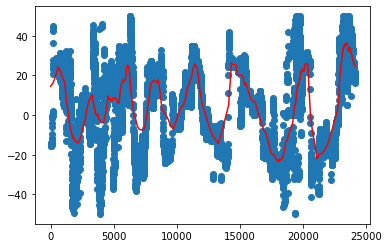

In [5]:
plt.scatter(distance_data, grade_data)
plt.plot(distance_data, grade_smooth, 'r')

In [6]:
grade_data = grade_smooth

print(len(grade_data))

n = distance_data.shape[0]
to_stay = np.zeros(n)
to_stay[0] = 1

for i in range(n - 1):
    if np.abs(grade_data[i+1] - grade_data[i]) < 1:
        grade_data[i+1] = grade_data[i]
        to_stay[i+1] = 0
    elif np.sign(grade_data[i+1]) != np.sign(grade_data[i]):
        to_stay[i + 1] = 1
    else:
        to_stay[i + 1] = 1
        
to_stay[-1] = 1

grade_data = grade_data[to_stay == 1]
distance_data = distance_data[to_stay == 1]
elevation_data = elevation_data[to_stay == 1]

print(len(grade_data))

13385
505


In [7]:
# n = grade_smooth.shape[0]
# to_stay = np.zeros(n)
# to_stay[0] = 1

# for i in range(n - 1):
#     if (np.abs(grade_smooth[i+1] - grade_smooth[i]) < 15) and (grade_smooth[i+1] * grade_smooth[i] > 0):
#         grade_smooth[i+1] = grade_smooth[i]

In [8]:
grade_data = np.arctan(grade_data/100)

In [9]:
distance = distance_data[-1]

x_data = distance_data/(distance_data[-1])
slope_data = grade_data

In [10]:
# create GEKKO model
m = GEKKO()

In [11]:
t_min = 1 * 60 * 60
t_est = 4 * 60 * 60
t_max = 8 * 60 * 60

In [12]:
# constants
N_m = 0.0222
E0 = 1400
X = distance
tau = 0.67
g = 9.81
k = 0.03734
mass = 55
S = 22

In [13]:
# equation parts
alpha = (np.sqrt(S/tau) * X)/E0
gamma = X/np.sqrt(S * tau**3)
delta = (g*X)/(S*tau)

In [14]:
# scales
u_scale = np.sqrt(S/tau)
v_scale = np.sqrt(S*tau)
t_scale = X/v_scale

In [15]:
# scaled values
sigma0 = 1
e0 = 1
x0 = 0
v0 = 0

e_crit = 0.15 * e0

In [16]:
# slope data to create spline
# x_data = np.linspace(0, 1, 10)
# slope_data = np.array(1*[1/18 * np.pi] + 1 * [-1/18 * np.pi] + 1 *[1/36 * np.pi] + 1 * [-1/36 * np.pi] + 1 * [1/9 * np.pi] + 1*[1/18 * np.pi] + 1 * [-1/18 * np.pi] + 1*[1/36 * np.pi] + 1 * [-1/36 * np.pi] + 1 * [1/9 * np.pi])

In [17]:
# time points [s]
nt = 201
tm = np.linspace(0,1,nt)
m.time = tm

In [18]:
# Variables
v = m.Var(value=0.0, lb=0.0, ub=6/v_scale) #velocity
E = m.Var(value=e0, lb=0.0, ub=e0) #energy
x = m.Var(value=0.0) #horizontal coordinate
sigma = m.Const(value=1.0)
slope = m.Var(value=slope_data[0]) #slope

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

In [19]:
tf = m.FV(value=t_est/t_scale, lb = t_min/t_scale, ub=t_max/t_scale)
tf.STATUS = 1

In [20]:
# MV
u = m.MV(value=0,lb=0,ub=9.6/u_scale)
u.STATUS = 1

In [21]:
# slope
m.cspline(x, slope, x_data, slope_data, True)

In [22]:
# equations
m.Equation(E.dt()==(alpha * (sigma - u * v))*tf)
m.Equation(v.dt()==(gamma * (u - v) - delta * m.sin(slope)) * tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation((distance - X*x)*final<=0)
m.Equation(sigma - u * v <= 0)

m.fix_final(E, 0)

In [23]:
m.options.IMODE = 6
m.options.MAX_ITER=15000
m.options.SOLVER=3
# m.options.RTOL=1e-4
# m.options.OTOL=1e-4

m.solve()

print('Final Time: ' + str(tf.value[0] * t_scale))

tm = tm * tf.value[0] * t_scale

apm 90.156.80.122_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            1
   Variables    :            9
   Intermediates:            0
   Connections  :            4
   Equations    :            5
   Residuals    :            5
 
 Number of state variables:           2799
 Number of total equations: -         2600
 Number of slack variables: -          400
 ---------------------------------------
 Degrees of freedom       :           -201
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This 

  69  8.4347102e-01 1.85e+04 3.01e+06   2.2 9.51e+03    -  3.04e-03 1.78e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  8.4347101e-01 1.85e+04 3.01e+06  -4.7 5.47e+03   0.1 4.79e-04 1.57e-03h  1
  71  8.4924095e-01 1.83e+04 3.00e+06   2.1 3.28e+03  -0.4 2.47e-03 1.06e-02f  1
  72  8.4950445e-01 1.82e+04 2.99e+06   0.2 1.43e+04    -  9.80e-03 3.37e-03h  1
  73  9.2784114e-01 1.81e+04 2.97e+06   2.5 1.50e+04    -  1.05e-02 5.76e-03f  1
  74  9.8136264e-01 1.81e+04 2.96e+06   2.6 1.58e+04    -  6.24e-03 2.94e-03f  1
  75  1.0656009e+00 1.80e+04 2.95e+06   2.6 1.33e+04    -  1.64e-02 4.61e-03f  1
  76  2.0398348e+00 1.70e+04 8.40e+06   2.6 4.11e+03    -  8.63e-03 5.24e-02f  1
  77  2.2009748e+00 1.69e+04 8.31e+06   2.6 3.20e+03    -  7.30e-03 8.59e-03f  1
  78  2.2532117e+00 1.68e+04 8.25e+06   2.1 1.00e+04    -  8.60e-03 7.45e-03f  1
  79  2.2533186e+00 1.67e+04 8.19e+06  -0.5 1.21e+04    -  9.07e-03 6.55e-03h  1
iter    objective    inf_pr 

 163  1.1004750e+01 7.59e+03 2.14e+07   2.6 1.30e+03   1.0 1.26e-04 5.59e-03f  1
 164  1.1004799e+01 7.57e+03 2.14e+07   2.6 2.40e+03   0.6 2.04e-03 2.72e-03h  1
 165  1.1004857e+01 7.56e+03 2.13e+07   2.6 2.78e+03   0.1 5.63e-03 1.07e-03h  1
 166  1.1004868e+01 7.56e+03 2.13e+07   2.6 3.65e+03   0.5 1.27e-03 5.69e-04h  1
 167  1.1004912e+01 7.55e+03 2.13e+07   2.3 3.22e+03   0.0 1.66e-02 1.34e-03h  1
 168  1.1005436e+01 7.38e+03 2.09e+07   2.6 9.50e+02   0.5 1.33e-03 2.29e-02f  1
 169  1.1005648e+01 7.35e+03 2.09e+07   2.6 5.42e+03  -0.0 2.28e-03 3.09e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.1005671e+01 7.35e+03 2.08e+07   2.6 3.85e+03   0.4 7.32e-05 8.70e-04h  1
 171  1.1005958e+01 7.13e+03 2.03e+07   2.6 1.36e+03   0.8 1.82e-02 2.98e-02f  1
 172  1.1005958e+01 7.11e+03 2.02e+07  -3.7 4.00e+03   0.4 4.70e-04 2.39e-03h  1
 173  1.1005971e+01 7.10e+03 2.02e+07   2.6 1.27e+03   0.8 8.56e-03 1.16e-03h  1
 174  1.1006300e+01 7.03e+03

 257  1.1039988e+01 4.04e+03 2.27e+07   2.6 5.87e+02   0.4 1.83e-03 7.21e-03f  1
 258  1.1040025e+01 4.04e+03 2.27e+07   2.6 1.88e+03  -0.0 3.28e-04 5.28e-04h  1
 259  1.1040025e+01 4.04e+03 2.27e+07   0.7 4.84e+02   0.4 1.48e-02 1.64e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  1.1040680e+01 4.01e+03 2.25e+07   2.6 2.36e+03  -0.1 4.97e-04 8.17e-03f  1
 261  1.1041966e+01 3.84e+03 2.16e+07   2.6 6.54e+02   0.3 3.66e-03 4.27e-02f  1
 262  1.1041968e+01 3.84e+03 2.16e+07   2.6 9.77e+03  -0.1 4.91e-03 2.19e-05h  1
 263  1.1041968e+01 3.82e+03 2.15e+07  -3.6 4.73e+02   0.3 1.86e-02 3.47e-03h  1
 264  1.1042237e+01 3.81e+03 2.14e+07   2.6 1.85e+03  -0.2 1.63e-04 2.66e-03f  1
 265  1.1042302e+01 3.81e+03 2.14e+07   2.6 1.18e+04  -0.7 2.03e-03 2.16e-04h  1
 266  1.1042525e+01 3.80e+03 2.14e+07   2.6 1.23e+03  -0.2 2.20e-03 1.96e-03h  1
 267  1.1044502e+01 3.58e+03 2.89e+07   2.5 5.39e+02   0.2 2.16e-02 5.84e-02h  1
 268  1.1044502e+01 3.57e+03

 351  1.1497921e+01 1.57e+03 3.20e+07   2.6 1.60e+03    -  1.15e-03 8.04e-03f  1
 352  1.2237014e+01 1.52e+03 3.11e+07   2.5 1.59e+03    -  1.82e-02 3.09e-02f  1
 353  1.2237064e+01 1.51e+03 3.09e+07   2.6 6.39e+02   0.9 1.70e-02 6.71e-03h  1
 354  1.2237095e+01 1.49e+03 3.05e+07   2.6 1.71e+03   1.3 5.81e-04 1.10e-02h  1
 355  1.2237127e+01 1.45e+03 2.95e+07   2.6 3.80e+02   1.8 2.19e-02 3.03e-02h  1
 356  1.2237176e+01 1.43e+03 2.91e+07   2.6 5.12e+02   1.3 2.69e-02 1.57e-02f  1
 357  1.2237176e+01 1.42e+03 2.90e+07  -3.7 8.46e+02   0.8 1.01e-04 4.16e-03h  1
 358  1.2237180e+01 1.40e+03 2.83e+07   1.6 3.44e+02   1.2 1.63e-01 1.16e-02h  1
 359  1.2237204e+01 1.38e+03 2.83e+07   2.6 2.80e+02   1.6 1.12e-01 1.82e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  1.2237200e+01 1.37e+03 2.77e+07  -3.7 2.19e+03    -  1.22e-03 3.21e-03h  1
 361  1.2237308e+01 1.30e+03 1.98e+07   2.3 7.69e+02   1.2 3.80e-02 5.58e-02h  1
 362  1.2237315e+01 1.30e+03

Final Time: 6611.708929022628


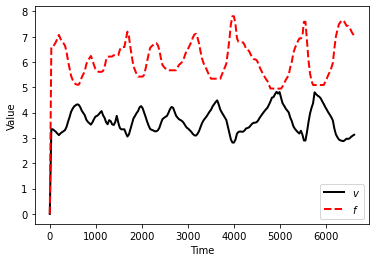

In [24]:
plt.figure(1)
plt.plot(tm,np.array(v.value) * v_scale,'k-',lw=2,label=r'$v$')
plt.plot(tm,np.array(u.value) * u_scale,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

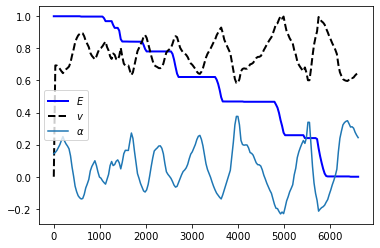

In [25]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
plt.plot(tm,slope, label=r'$\alpha$')
plt.legend()
plt.show()

In [26]:
5496.557240864244
5470.811627159549

5470.811627159549